# Introdução à modelagem ARIMA - Autoregressive Integrated Moving Average 

    Dataset https://github.com/RodrigoCBS/python-data-science/blob/master/vendas%20por%20mes.xlsx


## Objetivos:

    Criar um modelo de previsões baseado em ARIMA, fazer um sistema de testes e de melhoria no modelo, avaliar a previsibilidade de vendas mensais de um comércio atacadista.

### 1 - Introdução

    O dataset é formado por series temporais,ou seja, é uma coleção de observações feitas sequencialmente ao longo do tempo. Em séries temporais a ordem dos dados é fundamental. Uma característica muito importante deste tipo de dados é que as observações vizinhas são dependentes e o interesse é analisar e modelar essa dependência.

    O modelo ARIMA é um modelo estatístico baseado em séries temporais. Particularmente em análise de séries temporais, um modelo auto-regressivo integrado de médias móveis (autoregressive integrated moving average ou ARIMA, na sigla em inglês) tem seus parametros ajustados aos dados da série temporal para entender melhor os dados ou para prever pontos futuros na série. Modelos ARIMA são aplicados em alguns casos em que os dados mostram evidências de não estacionariedade, em que um passo inicial de diferenciação (correspondente à parte "integrada" do modelo) pode ser aplicado uma ou mais vezes para eliminar a não estacionariedade.

    A parte auto-regressiva (AR) do modelo ARIMA indica que a variável evoluinte de interesse é regressada em seus próprios valores defasados, isto é, anteriores. A parte de média móvel (MA) indica que o erro de regressão é na verdade uma combinação linear dos termos de erro, cujos valores ocorreram contemporaneamente e em vários momentos no passado. A parte integrada (I) indica que os valores de dados foram substituídos com a diferença entre seus valores e os valores anteriores e este processo diferenciador pode ter sido realizado mais de uma vez. O propósito da cada uma destas características é fazer o modelo se ajustar aos dados da melhor forma possível.
    
    Para fazer esse ajuste vamos fazer alguns testes. 
   

### 2 - Importando bibliotecas e o dataset

    Fiz os imports necessários para rodar o modelo, testá-lo e plotar os graficos para análise.
    
   #### Dataset
       O dataset é formado por duas colunas, uma com as datas e outra com as vendas em unidades. São 105 coletas de dados para podermos fazer nossa modelagem.

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np

#header para ter o cabeçalho
serieVendas = pd.read_excel('vendas por mes.xlsx', header=0, parse_dates=[0],index_col=0)
serieVendas.head()


,mês
data,
2012-01-01,585
2012-02-01,395
2012-03-01,468
2012-04-01,687
2012-05-01,613


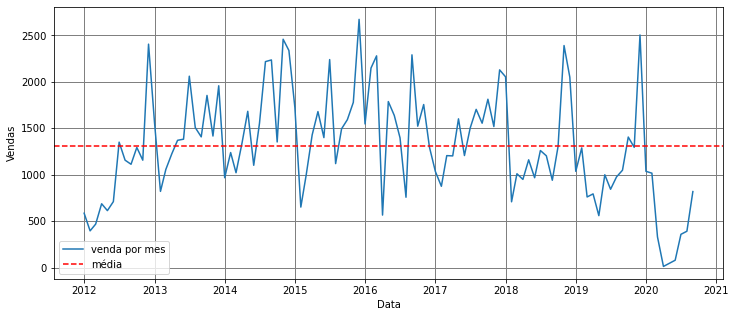

In [17]:
plt.figure(figsize=(12,5))
plt.plot(serieVendas,label='venda por mes')
plt.axhline(serieVendas['mês'].mean(),linestyle='--',color='red',label='média')
plt.grid(color='grey', linestyle='-', linewidth=1)
plt.xlabel('Data')
plt.ylabel('Vendas')
plt.legend()

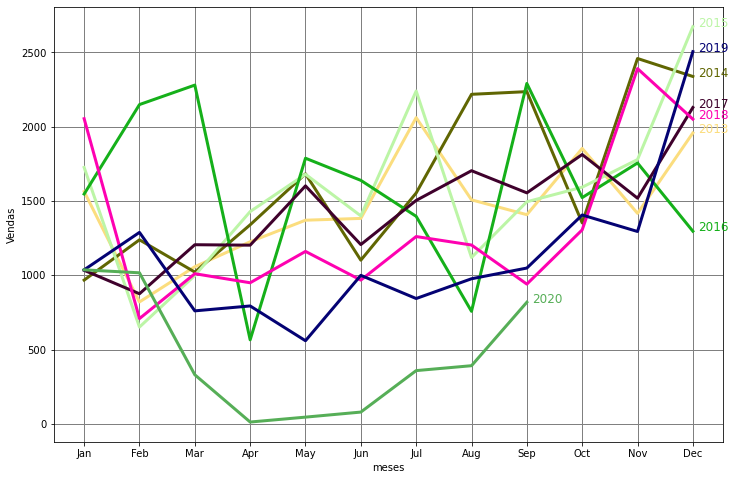

In [18]:
import matplotlib as mpl
df = serieVendas.reset_index().copy()

#criar coluna ano e mês para percorrer os dados
df['year'] = [d.year for d in df.data]
df['month'] = [d.strftime('%b') for d in df.data]
years = df['year'].unique()

# preparar cores de forma randômica
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(years), replace=False)

# plotar o gráfico com linhas para cada ano em separado
plt.figure(figsize=(12,8))
for i, y in enumerate(years):
    if i > 0:        
        plt.plot('month', 'mês', data=df.loc[df.year==y, :], color=mycolors[i], label=y,linewidth=3)
        plt.text(df.loc[df.year==y, :].shape[0]-.9, df.loc[df.year==y, 'mês'][-1:].values[0], y, fontsize=12, color=mycolors[i])

plt.grid(color='grey', linestyle='-', linewidth=1)
plt.xlabel('meses')
plt.ylabel('Vendas')
plt.show()

### 3 - O que estamos vendo ai?
    Plotado o gráfico podemos ver a evolução das vendas pelo tempo, aparentemente há uma tendência, o comeco do ano é de 
menor número de peças vendidas , a medida que vai chegando perto do final do ano as vendas sobem. Algo de certo modo esperado pelo fluxo de dinheiro maior no final do ano devido ao 13º e natal.

    2016 foi um caso atípico e teve os melhores meses no começo do ano e 2020 foi muito afetado pela pandemia.
    
    Isso não traz muito o com que trabalharmos,vamos explorar mais algumas informações!
    
### 4 - Vamos analisar nossa série temporal !

   #### 4.1 - O primeiro passo é fazer a decomposição da série temporal 
   
    Qualquer serie temporal pode ser dividida em Nível Basal + Tendencia + Sazonalidade + Erro

    Uma tendência é observada quando há um acrécimo ou decrécimo na inclinação observável da série temporal. Enquanto a sazonalidade é percebida quando a um padrão de repetição em um intervalo regular. Isso pode ser pelo horário do dia, dia do mes ou da semana , mês ou ano.
    De toda forma uma série temporal pode não ter uma tendência e/ou sazonalidade. 
    
    O Python tem a função de decomposição, vamos utilizá-la e ver o que podemos tirar de informação.

Text(0, 0.98, 'decomposição aditiva')

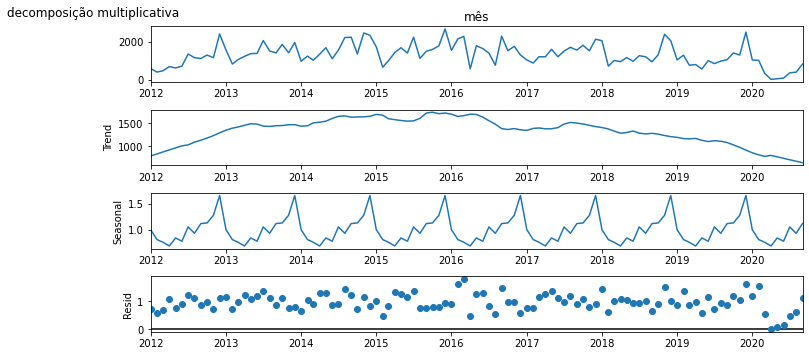

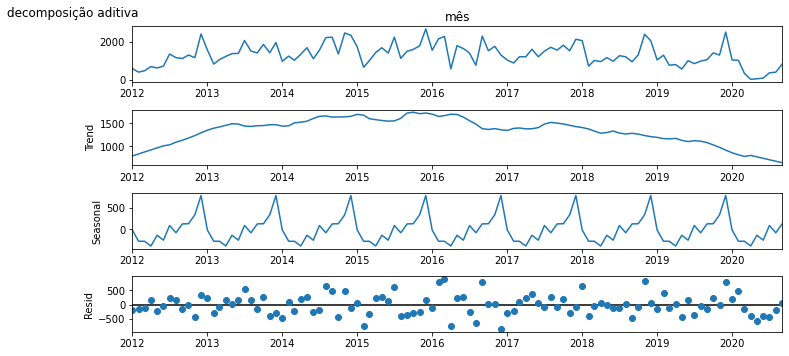

In [19]:
#importando a decomposição temporal 
from statsmodels.tsa.seasonal import seasonal_decompose

#decomposição aditiva
resultado_decomposicao_aditiva = seasonal_decompose(serieVendas['mês'], model='additive', extrapolate_trend='freq')

#decomposição multiplicativa
resultado_decomposicao_multiplicativa = seasonal_decompose(serieVendas['mês'], model='multiplicative', extrapolate_trend='freq')


plt.rcParams.update({'figure.figsize': (10,5)})
resultado_decomposicao_multiplicativa.plot().suptitle('decomposição multiplicativa',x= 0, fontsize=12)
resultado_decomposicao_aditiva.plot().suptitle('decomposição aditiva',x= 0, fontsize=12)


   #### 4.2 Primeiras análises
    Comforme esperado a sazonalidade existe. As vendas seguem um padrao de crescimento até o final do ano.
    A tendência foi de crescimento até meados de 2014, estabilizando em 2015 ate começo de 2016 e caindo ate 2019, 2020 teve uma queda ainda maior e a tendência ainda é de queda.
    Fatores político-econômicos podem ter influência sobre essa tendência,ou produtos novos não agradando clientes, ou ainda mudanças de mercado. Para entender essa tendência precisamos investigar juntamente com os donos do negócio.
    
   #### 4.3 - Verificar a Autocorrelação  
    Em uma série temporal, não há como desconsiderar a estrutura de dependência das observações. A quantidade vendida em Fevereiro pode estar relacionada à vendida em Janeiro, mas a utilização desses modelos pode gerar resultados enviesados e que não refletem a realidade.

    A autocorrelação é definida como uma observação num determinado instante está relacionada às observações passadas.

    As observações podem estar autocorrelacionadas em diversas ordens. A autocorrelação de primeira ordem caracteriza séries onde uma observação está correlacionada com a observação imediatamente anterior. A autocorrelação de segunda ordem caracteriza séries temporais onde uma observação está correlacionada com as observações a 2 unidades de tempo no passado. Essas unidades temporais são chamadas de "lag"

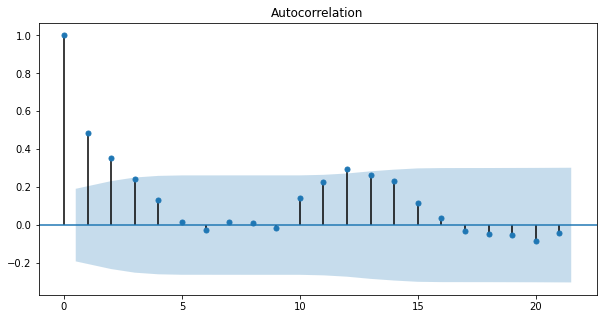

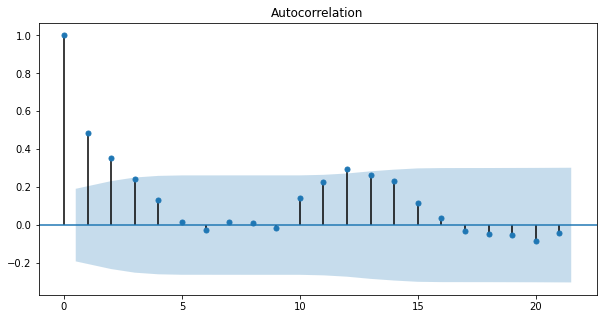

In [20]:
# importamos a biblioteca statsmodels.graphics.tsaplots e utilizamos o plot_acf para plotar a função autocorrelação
plot_acf(serieVendas)

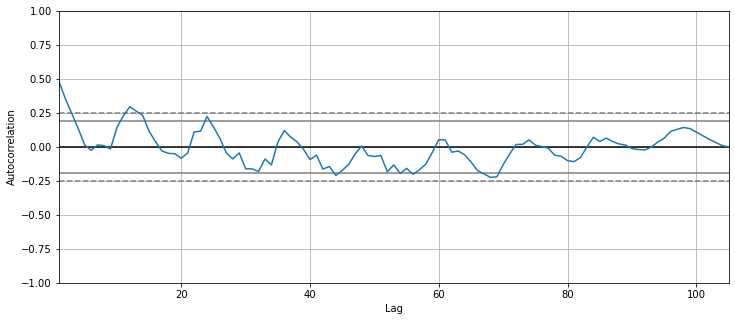

In [21]:
# a biblioteca Pandas também tem a função de autocorrelação embarcada
plt.figure(figsize=(12,5))
pd.plotting.autocorrelation_plot(serieVendas)

   #### 4.4 - O que podemos falar da autocorrelação ? 
    A auto correlação dos dados é bem forte até o 5º "lag", tendo alguns picos em outros tempos, como verificamos que a sazonalidade parece ser de um ano, vamos considerar também o 12º "lag"
    Essa informação será util para podermos modelar nossa serie temporal dentro do ARIMA. 



### 5 - ARIMA usando Python

    Já está importada a bibilioteca "statsmodels.tsa.arima_model" para fazer o 'fit' no modelo ARIMA.

    Um modelo de ARIMA pode ser criado usando :

1) chamando o construtor ARIMA() e passando os parametros p, d e q;
2) passando os dados de treinamento usando o fit()
3) usando a função predict() e informando uma data para a predição.


    os parametros citados p, d e q são :

    P = a quantidade de intervalos de observação (lag). Como vimos no gráfico acima, até o 5 é o ideal.
    D = é o grau de diferenciação, ou seja, o numero de vezes que o dado terá o valor anterior subitraido.
    Q = é o tamanho da janela da média movél.

    no modelo ARIMA , o AR é dado pelo p, o I pelo d e o MA pelo q. 

    se deixarmos algum parametro em zero, iremos mudar o tipo de modelo.

    Começando com algo simples:
    vamos fitar o modelo usando o dataset do shampoo e vamos ver os erros residuais.

    o primeiro teste vamos fitar o ARIMA em (5,1,0) :
    5 para o parametro p, que é a autoregressão
    1 para o parametro d, que é o integrador, no caso vai deixar a serie temporal estacionária. 
    0 para o parametro q, que é a média móvel, no caso não vai existir. 

    Nosso modelo então será ARI.

                             ARIMA Model Results                              
Dep. Variable:                  D.mês   No. Observations:                  104
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -796.906
Method:                       css-mle   S.D. of innovations            513.788
Date:                Fri, 16 Oct 2020   AIC                           1607.811
Time:                        23:01:42   BIC                           1626.322
Sample:                    02-01-2012   HQIC                          1615.311
                         - 09-01-2020                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.2332     23.155     -0.010      0.992     -45.617      45.150
ar.L1.D.mês    -0.5097      0.097     -5.229      0.000      -0.701      -0.319
ar.L2.D.mês    -0.2892      0.109     -2.653    

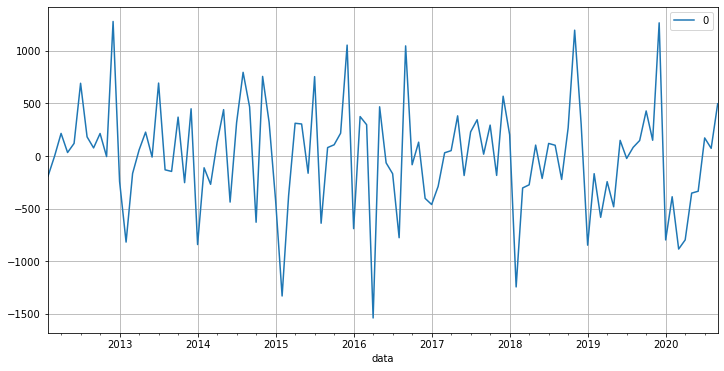

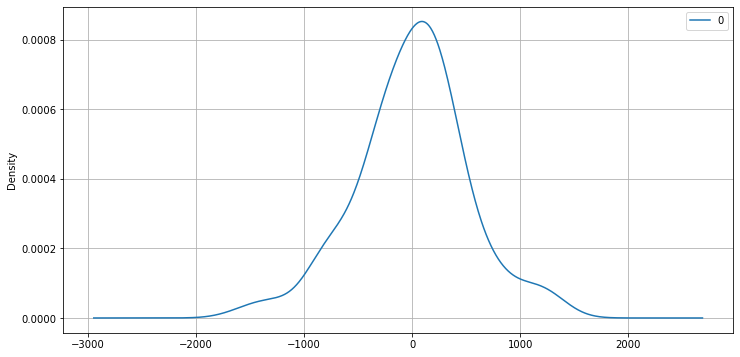

In [22]:
import warnings
warnings.filterwarnings("ignore")

# fit do modelo
modelo = ARIMA(serieVendas, order=(5,1,0))
modelo_fitado = modelo.fit(disp=0)
print(modelo_fitado.summary())

# plotar os erros residuais
residuais = pd.DataFrame(modelo_fitado.resid)

residuais.plot(grid = True, figsize=(12,6))

residuais.plot(kind='kde',grid = True, figsize=(12,6))

print(residuais.describe())

#### 5.1 - Primeira impressão
    Os erros seguem uma distribuição parecida com normal o que é bom , mas está tendencioso a errar positivo. 
    Vamos então dividir os dados em treino e teste, sendo 2/3 para treino e 1/3 para teste. Poderemos observar os resultados desse primeiro modelo ARIMA como a curva do modelo vs a curva real, os valores previstos e os reais e ainda uma medida de erro.

In [23]:
X = serieVendas.values
tamanho = int(len(X) * 0.66)
train, test = X[0:tamanho], X[tamanho:]
historico = [x for x in train]
predicoes = list()
for t in range(len(test)):
    model = ARIMA(historico, order=(5,1,0))
    model_fit = model.fit(disp=0)
    saida = model_fit.forecast()
    predicoes.append(saida[0])
    historico.append(test[t])
    print('previsto = %f, esperado = %f' % (aux, aux2))
erro = np.sqrt(mean_squared_error(test, predicoes))
print('Teste RMSE: %.3f' % erro)

# plot
plt.figure(figsize=(12,5))

plt.grid(color='grey', linestyle='-', linewidth=1)
plt.plot(test)
plt.plot(predicoes, color='red')

NameError: name 'aux' is not defined

##### 5.2 - Análise do primeiro modelo

    Os erros dos modelos podem ser avaliados de 4 formas principais : ME (erro médio), MAE (Erro médio Absoluto) MSE (Erro Quadrático Médio) e RMSE (Raiz do Erro Quadrático Médio)
    A medida mais simples é o Erro Médio (ME) que é literalmente a média da soma dos erros. O problema é que essa medida tem grande viés e um erro muito grande positivo ou negativo pode trazer a média para próximo de zero. Para melhorar essa medição , o MAE foi criado, simplesmente trabalhando com todos os valores de erro absolutos, fazendo com que o viés seja contornado. O MAE é considerado preciso e robusto como medida da habilidade de modelos numéricos em reproduzir a realidade.
    O MSE é similar ao MAE, porém mais sensível aos grandes erros, por elevar as diferenças individuais ao quadrado. MSE é sempre positivo. MSE = 0 indica simulação perfeita. 
    Finalmente em adição ao MSE, a raiz quadrada de MSE, (RMSE em Inglês), é comumente usada para expressar a acurácia dos resultados numéricos com a vantagem de que RMSE apresenta valores do erro nas mesmas dimensões da variável analisada.
    
###### Nosso primeiro modelo teve uma raiz do erro médio quadrado RMSE de 557. Considero um erro alto ja que a média de vendas desse data frame está em 1278 unidades por mês.

#### 5.3 - tentando melhorar o modelo 

    Vamos utilizar duas funções para executar os testes a primeira fará o teste igual ao que fizemos anteriormente, já a segunda vai iterar sobre alguns valores, isso vai demorar, mesmo para uma quantidade de dados pequena como essa.
    
    Então passa um café, estica as costas, veja um video engraçado enquanto o computador faz esses cálculos.

O programa irá fazer iterações para :

p = 0, 1, 5, 8, 12

d = 0, 1, 2, 3

q = 0, 1, 2, 3

E para cada combinação vai testar e achar o RMSE. O que tiver menor valor vamos utilizar em nosso modelo final. 

In [ ]:
def evaluate_arima_model(X, arima_order):
    tamanho = int(len(X) * 0.66)
    train, test = X[0:tamanho], X[tamanho:]
    historico = [x for x in train]
    predicoes = list()
    for t in range(len(test)):
        model = ARIMA(historico, order=arima_order)
        model_fit = model.fit(disp=0)
        saida = model_fit.forecast()
        predicoes.append(saida[0])
        historico.append(test[t])
    erro = np.sqrt(mean_squared_error(test, predicoes))
    return erro

def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [ ]:
p_values = [0, 1, 5, 8, 12]
d_values = range(0, 3)
q_values = range(0, 3)
evaluate_models(serieVendas.values, p_values, d_values, q_values)

#### 5.4 - melhor modelo ARIMA
    Simulações feitas!! (avisei que ia demorar) 
    O programa achou o modelo ARIMA (12,0,0) com o erro RMSE 471,63 , são 86 pontos abaixo de erro em relação ao primeiro teste. Melhorou bem torno de 15% menos erro, não foi o melhor modelo do mundo, mas muito provavelmente os resultados de vendas de 2020 ficam muito difíceis do modelo prever e causam esse erro tão alto.
    Vamos testar esse mesmo modelo desconsiderando o ano de 2020.
    

Teste RMSE: 421.307


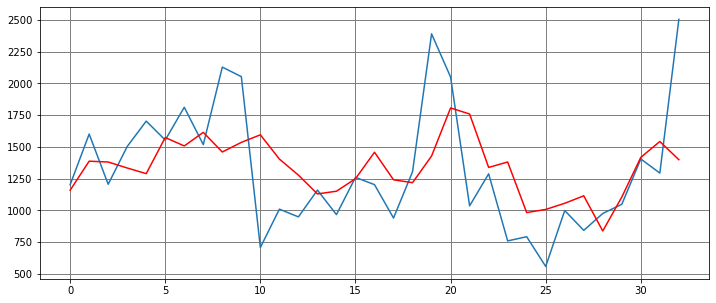

In [24]:
X = serieVendas.values[:-9]
tamanho = int(len(X) * 0.66)
train, test = X[0:tamanho], X[tamanho:]
historico = [x for x in train]
predicoes = list()
for t in range(len(test)):
    model = ARIMA(historico, order=(12,0,0))
    model_fit = model.fit(disp=0)
    saida = model_fit.forecast()
    predicoes.append(saida[0])
    historico.append(test[t])
erro = np.sqrt(mean_squared_error(test, predicoes))
print('Teste RMSE: %.3f' % erro)

# plot
plt.figure(figsize=(12,5))

plt.grid(color='grey', linestyle='-', linewidth=1)
plt.plot(test)
plt.plot(predicoes, color='red')

#### 5.5 - Melhor modelo ARIMA - Sem 2020

    O RMSE caiu para 421.30, em relação ao primeiro modelo são mais de 100 pontos. Provavelmente sem 2020 outra combinação de paramêtros poderia ser mais acertiva. Só não vou re-executar o código pois estou feliz com essas analises.

## conclusões

A modelagem ARIMA é relativamente simples de ser feita e testada, e para series temporais realmente é muito facil ver o resultado do modelo estatístico.

O tipo de caso estudado, vendas reais de uma empresa, deve levar muitos fatores em consideração que o modelo não pode prever, como variações na economia, lançamentos de produtos, esforços de venda , promoções etc. 

Foi um estudo muito legal de ser feito pois além de entender como funciona o modelo ARIMA também passamos por , avaliações de erros estatísticos, plotagem de auto-correlação, decomposição e trabalhar com séries temporais.


## Bibliografia
https://www.machinelearningplus.com/time-series/time-series-analysis-python/

https://www.scielo.br/scielo.php?script=sci_arttext&pid=S0102-77862011000400009#:~:text=Em%20adição%20ao%20MSE%2C%20a,mesmas%20dimensões%20da%20variável%20analisada.

https://pt.wikipedia.org/wiki/ARIMA

https://operdata.com.br/blog/caracteristicas-das-series-temporais/

https://www.kaggle.com/virosky/how-to-manage-a-solar-power-plant
